### Домашняя работа 4-го урока

#### Расскажите, как работает регуляризация в решающих деревьях, какие параметры мы штрафуем в данных алгоритмах?

Для любой выборки можно построить решающее дерево,не допускающее на ней ни одной ошибки, в каждом листе которого находится ровно по
одному объекту выборки. Скорее всего, это дерево будет переобученным и не сможет показать хорошее качество на новых данных.

Чтобы избежать переобучения, мы должны добавить параметры регуляризации в модель.
Можно придумать большое количество способов регулярицации. 
Перечислим некоторые:
* Ограничение максимальной глубины дерева (max_depth).
* Ограничение минимального числа объектов в листе (min_samples_leaf).
* Ограничение максимального количества листьев в дереве.
* Ограничение в случае, если все объекты в листе относятся к одному классу.
* Требование, что функционал качества при дроблении улучшался как минимум на s процентов.


С помощью грамотного выбора подобных критериев и их параметров можно существенно повлиять на качество дерева.
Тем не менее, такой подбор является трудозатратным и требует проведения кросс-валидации.



#### По какому принципу рассчитывается "важность признака (feature_importance)" в ансамблях деревьев?

Под важностью характеристик подразумеваем те, которые оказали наибольшее влияние на объяснение конкретного наблюдения, введенного в модель. Например, в случае кредитного рейтинга мы могли бы сказать, что эти функции оказали наибольшее влияние на определение кредитного рейтинга клиента.

Есть много способов рассчитать оценки важности функций и множество моделей, которые можно использовать для этой цели.
Возможно, самый простой способ - вычислить простую статистику коэффициентов между каждой функцией и целевой переменной.


Может быть и такое определение : отношение между количеством выборок, направляемых в узел принятия решения с участием этого признака в любом из деревьев ансамбля, и общим количеством выборок в обучающем наборе.
Функции, участвующие в узлах верхнего уровня деревьев решений, имеют тенденцию видеть больше выборок, следовательно, они, вероятно, будут иметь большую важность.

 

### Укажите, пожалуйста, ваш ник на kaggle.

In [ ]:
Мой ник:AlexLo80. Результат - 0,60162

# Курсовой проект,продолжение. Прошу прощения акцент был на материалы 3-4 урока. Статистический анализ признаков сюда не перенес.

### Загрузка необходимых библиотек

In [82]:
import pandas as pd
import numpy as np
import pickle
import random
from pathlib import Path


from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Путь к файлам

In [83]:
DATA_ROOT = Path('data/course_project')
MODELS_PATH = Path('data/course_project/models/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / 'train.csv'
TEST_DATASET_PATH =  DATA_ROOT / 'test.csv'


### Функция для отчистки пропущенных данных через медианы

In [84]:
def cleaning(df):
    # убьем 'renewable energy'
    df = df[df['Purpose']!='renewable energy']

    CAT_FEATURE_NAMES = []
    # категории заполняем дамми данными
    for cat_colname in df.select_dtypes(include='object').columns:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
        # делаем список категорий
        CAT_FEATURE_NAMES.append(cat_colname)
    
    # находим столбцы с пропусками
    col_wo_cat = []
    for col in df.columns:
        count = df[col].count()
        if count < df.shape[0]:
            col_wo_cat.append (col)
    
    # удаляем из списка, для отдельной обработки
    col_wo_cat.remove('Years in current job')
    
            
#      заполняем категорию самым  частым значением
    df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].describe().top
    
    
    #переводим в числа столбец категорий
    df['Credit Score'] = pd.to_numeric(df['Credit Score'], errors='coerce')
    
#     заполняем медианами числовые пропуски
    for col in col_wo_cat:
        if df[col].isna().sum() > 0:
            df.loc[df[col].isna(), col] = df[col].median()

    
    # создали Id и индексировали по этому столбу
    df['Id'] = 0
    df['Id'] = df.index 
    
    return df


### Балансировка данных

In [85]:
def balance_df_by_target(df, target_name, method):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

### Функция для вывода отчета о результатах работы модели

In [86]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred,model):
    print(model)
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

### Функция для оценки работы модели

In [87]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred,model)

### Функция для заполнения пропусков  с помощью модели

In [88]:
def imputer_rfr(data, target_col):
    
    # Хорошо работает, если только в одном столбце отстутствуют данные
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    
    
    return data

### Обработка пропущенных данных с помощью функции imputer

In [89]:
# определелили список категорий
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                             'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                             'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score',
                     'Credit Default']
data = df_train[NUM_FEATURE_NAMES]

def empties(df):
#определяем категории с пропусками
    col_wo_cat = []
    for col in df.columns:
        count = df[col].count()
        if count < df.shape[0]:
            col_wo_cat.append (col)
    return col_wo_cat

col_wo_cat = empties(data)
for i in range (len(col_wo_cat)):
    col_wo_cat = empties(data)
    target_col = col_wo_cat [-1]
    # col_wo_cat

    NUM_FEATURE_full= [item for item in NUM_FEATURE_NAMES if item not in col_wo_cat]+[target_col]
    df_reduced = data[NUM_FEATURE_full]

    df_r_filled = imputer_rfr (df_reduced,target_col)
    df_filled = df_r_filled[target_col]

    df2 = data.drop([target_col], axis=1)
    frames = [df_filled, df2]
    data = pd.concat(frames, axis=1, join="inner")
    data.info()    

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\lobapid3\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
[Parallel(n_

r2 на train: 0.49118028537608793
r2 на test: 0.18245185572587053
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Credit Score                  7500 non-null   float64
 1   Annual Income                 5943 non-null   float64
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Months since last delinquent  3419 non-null   float64
 8   Bankruptcies                  7486 non-null   float64
 9   Current Loan Amount           7500 non-null   float64
 10  Current Credit Balance        7500 non-null   float64
 11  Monthly Debt                  7500 non-null   float64
 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\lobapid3\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9248434731979835
r2 на test: 0.779296187958956
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Bankruptcies                  7500 non-null   float64
 1   Credit Score                  7500 non-null   float64
 2   Annual Income                 5943 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Current Loan Amount           7500 non-null   float64
 10  Current Credit Balance        7500 non-null   float64
 11  Monthly Debt                  7500 non-null   float64
 12  

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\lobapid3\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.4054901533035765
r2 на test: 0.041766050103018815
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Months since last delinquent  7500 non-null   float64
 1   Bankruptcies                  7500 non-null   float64
 2   Credit Score                  7500 non-null   float64
 3   Annual Income                 5943 non-null   float64
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Current Loan Amount           7500 non-null   float64
 10  Current Credit Balance        7500 non-null   float64
 11  Monthly Debt                  7500 non-null   float64
 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Все модели с базовыми параметрами с функцией и циклом, без масштабирования

In [90]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = df_train.copy()
df = cleaning(df_train)

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = cleaning(df_test)
  

def modeling (model,X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    y_pred_final = model.predict(df_test)
    return y_pred_final

# Отбор признаков
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score']
TARGET_NAME = 'Credit Default'

preds_final = pd.DataFrame()
preds_final['Id'] = df_test['Id'].copy()
df_test = df_test[NUM_FEATURE_NAMES]

# Разбиваем данные
X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

modellist = ['LogisticRegression','model_svm','model_knn','model_tree','model_xgb','model_lgbm','model_catb']
for mode in modellist:
    if mode == 'LogisticRegression':
        model = LogisticRegression()
    elif mode == 'model_svm':
        model = SVC()
    elif mode == 'model_knn':
        model = KNeighborsClassifier()
    elif mode == 'model_tree':
        model = DecisionTreeClassifier(random_state = 21, class_weight = {0:1, 1:3.6}, max_depth = 4)
    elif mode == 'model_xgb':
        model = xgb.XGBClassifier(random_state = 21)#,n_estimators = 100)
    elif mode == 'model_lgbm':
        model = lgbm.LGBMClassifier(random_state = 21, class_weight = {0:1, 1:3.6}) #,n_estimators= 100)
    elif mode == 'model_catb':
        model = catb.CatBoostClassifier(silent = True, random_state = 21)

    preds_final[TARGET_NAME] = modeling(model,X_train, X_test, y_train, y_test)
    output_file = 'submission.csv'
    output_dir = Path(MODELS_PATH/f'Func/{mode}')
    output_dir.mkdir(parents=True, exist_ok=True)
    preds_final.to_csv((output_dir / output_file), index=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
TRAIN

              precision    recall  f1-score   support

           0       0.76      0.98      0.86      3770
           1       0.82      0.20      0.33      1478

    accuracy                           0.76      5248
   macro avg       0.79      0.59      0.59      5248
weighted avg       0.78      0.76      0.71      5248

TEST

              precision    recall  f1-score   support

           0       0.76      0.98      0.85      1617
           1       0.79      0.21      0.33       633

    accuracy                           0.76      2250
   macro avg       0.77      0.59      0.59      2250
weighted avg       0.77      0.76      0.71      2250

CONFUSI

C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
TRAIN

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3770
           1       0.67      0.45      0.54      1478

    accuracy                           0.78      5248
   macro avg       0.74      0.68      0.70      5248
weighted avg       0.77      0.78      0.77      5248

TEST

              precision    recall  f1-score   support

           0       0.74      0.84      0.78      1617
           1       0.37      0.24      0.29       633

    accuracy                           0.67      2250
   macro avg       0.55      0.54      0.54      2250
weighted avg       0.63      0.67      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1352  265
1                479  154
DecisionTreeClassifier(c

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3770
           1       0.99      0.84      0.91      1478

    accuracy                           0.95      5248
   macro avg       0.97      0.92      0.94      5248
weighted avg       0.96      0.95      0.95      5248

TE

### Все модели с базовыми параметрами с функцией и циклом, без масштабирования, с балансировкой

In [91]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = df_train.copy()
df = cleaning(df_train)

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = cleaning(df_test)
  

def modeling (model,X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    y_pred_final = model.predict(df_test)
    return y_pred_final

# Отбор признаков
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score']
TARGET_NAME = 'Credit Default'

preds_final = pd.DataFrame()
preds_final['Id'] = df_test['Id'].copy()
df_test = df_test[NUM_FEATURE_NAMES]

# Разбиваем данные
X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)
# балансировка
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
df_balanced[TARGET_NAME].value_counts()
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]


modellist = ['LogisticRegression','model_svm','model_knn','model_tree','model_xgb','model_lgbm','model_catb']
for mode in modellist:
    if mode == 'LogisticRegression':
        model = LogisticRegression()
    elif mode == 'model_svm':
        model = SVC()
    elif mode == 'model_knn':
        model = KNeighborsClassifier()
    elif mode == 'model_tree':
        model = DecisionTreeClassifier(random_state = 21, class_weight = {0:1, 1:3.6}, max_depth = 4)
    elif mode == 'model_xgb':
        model = xgb.XGBClassifier(random_state = 21)#,n_estimators = 100)
    elif mode == 'model_lgbm':
        model = lgbm.LGBMClassifier(random_state = 21, class_weight = {0:1, 1:3.6}) #,n_estimators= 100)
    elif mode == 'model_catb':
        model = catb.CatBoostClassifier(silent = True, random_state = 21)

    preds_final[TARGET_NAME] = modeling(model,X_train_balanced, X_test, y_train_balanced, y_test)
    output_file = 'submission.csv'
    output_dir = Path(MODELS_PATH/f'Func/Bal/{mode}')
    output_dir.mkdir(parents=True, exist_ok=True)
    preds_final.to_csv((output_dir / output_file), index=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
TRAIN

              precision    recall  f1-score   support

           0       0.67      0.57      0.62      1478
           1       0.63      0.72      0.67      1478

    accuracy                           0.64      2956
   macro avg       0.65      0.64      0.64      2956
weighted avg       0.65      0.64      0.64      2956

TEST

              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1617
           1       0.38      0.66      0.48       633

    accuracy                           0.60      2250
   macro avg       0.59      0.62      0.57      2250
weighted avg       0.69      0.60      0.62      2250

CONFUSI

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1478
           1       0.99      0.99      0.99      1478

    accuracy                           0.99      2956
   macro avg       0.99      0.99      0.99      2956
weighted avg       0.99      0.99      0.99      2956

TE

### Все модели с базовыми параметрами с функцией и циклом, с масштабированием

In [92]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = df_train.copy()
df = cleaning(df_train)

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = cleaning(df_test)
  

def modeling (model,X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    y_pred_final = model.predict(df_test)
    return y_pred_final

# Отбор признаков
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score']
TARGET_NAME = 'Credit Default'

preds_final = pd.DataFrame()
preds_final['Id'] = df_test['Id'].copy()
df_test = df_test[NUM_FEATURE_NAMES]

# Масштабируем данные
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df = df_norm.copy()

# Разбиваем данные
X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

modellist = ['LogisticRegression','model_svm','model_knn','model_tree','model_xgb','model_lgbm','model_catb']
for mode in modellist:
    if mode == 'LogisticRegression':
        model = LogisticRegression()
    elif mode == 'model_svm':
        model = SVC()
    elif mode == 'model_knn':
        model = KNeighborsClassifier()
    elif mode == 'model_tree':
        model = DecisionTreeClassifier(random_state = 21, class_weight = {0:1, 1:3.6}, max_depth = 4)
    elif mode == 'model_xgb':
        model = xgb.XGBClassifier(random_state = 21)#,n_estimators = 100)
    elif mode == 'model_lgbm':
        model = lgbm.LGBMClassifier(random_state = 21, class_weight = {0:1, 1:3.6}) #,n_estimators= 100)
    elif mode == 'model_catb':
        model = catb.CatBoostClassifier(silent = True, random_state = 21)

    preds_final[TARGET_NAME] = modeling(model,X_train, X_test, y_train, y_test)
    output_file = 'submission.csv'
    output_dir = Path(MODELS_PATH/f'Func/Scal/{mode}')
    output_dir.mkdir(parents=True, exist_ok=True)
    preds_final.to_csv((output_dir / output_file), index=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
TRAIN

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3770
           1       0.98      0.19      0.32      1478

    accuracy                           0.77      5248
   macro avg       0.87      0.59      0.59      5248
weighted avg       0.82      0.77      0.71      5248

TEST

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1617
           1       0.98      0.19      0.32       633

    accuracy                           0.77      2250
   macro avg       0.87      0.60      0.59      2250
weighted avg       0.82      0.77      0.71      2250

CONFUSI

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3770
           1       0.99      0.84      0.91      1478

    accuracy                           0.95      5248
   macro avg       0.97      0.92      0.94      5248
weighted avg       0.96      0.95      0.95      5248

TE

### Все модели с базовыми параметрами с функцией и циклом, с масштабированием и балансировкой

In [93]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = df_train.copy()
df = cleaning(df_train)

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = cleaning(df_test)
  

def modeling (model,X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    y_pred_final = model.predict(df_test)
    return y_pred_final

# Отбор признаков
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score']
TARGET_NAME = 'Credit Default'

preds_final = pd.DataFrame()
preds_final['Id'] = df_test['Id'].copy()
df_test = df_test[NUM_FEATURE_NAMES]

# Масштабируем данные
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df = df_norm.copy()

# Разбиваем данные
X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)
# балансировка
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
df_balanced[TARGET_NAME].value_counts()
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

modellist = ['LogisticRegression','model_svm','model_knn','model_tree','model_xgb','model_lgbm','model_catb']
for mode in modellist:
    if mode == 'LogisticRegression':
        model = LogisticRegression()
    elif mode == 'model_svm':
        model = SVC()
    elif mode == 'model_knn':
        model = KNeighborsClassifier()
    elif mode == 'model_tree':
        model = DecisionTreeClassifier(random_state = 21, class_weight = {0:1, 1:3.6}, max_depth = 4)
    elif mode == 'model_xgb':
        model = xgb.XGBClassifier(random_state = 21)#,n_estimators = 100)
    elif mode == 'model_lgbm':
        model = lgbm.LGBMClassifier(random_state = 21, class_weight = {0:1, 1:3.6}) #,n_estimators= 100)
    elif mode == 'model_catb':
        model = catb.CatBoostClassifier(silent = True, random_state = 21)

    preds_final[TARGET_NAME] = modeling(model,X_train_balanced, X_test, y_train_balanced, y_test)
    output_file = 'submission.csv'
    output_dir = Path(MODELS_PATH/f'Func/Scal/Bal/{mode}')
    output_dir.mkdir(parents=True, exist_ok=True)
    preds_final.to_csv((output_dir / output_file), index=False)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
TRAIN

              precision    recall  f1-score   support

           0       0.65      0.60      0.62      1478
           1       0.63      0.68      0.66      1478

    accuracy                           0.64      2956
   macro avg       0.64      0.64      0.64      2956
weighted avg       0.64      0.64      0.64      2956

TEST

              precision    recall  f1-score   support

           0       0.80      0.57      0.67      1617
           1       0.37      0.64      0.47       633

    accuracy                           0.59      2250
   macro avg       0.58      0.60      0.57      2250
weighted avg       0.68      0.59      0.61      2250

CONFUSI

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
TRAIN

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1478
           1       1.00      0.99      0.99      1478

    accuracy                           0.99      2956
   macro avg       0.99      0.99      0.99      2956
weighted avg       0.99      0.99      0.99      2956

TE

### Все модели  с подбором параметров (RandomSearchCV), без масштабирования

In [94]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = df_train.copy()
df = cleaning(df_train)

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = cleaning(df_test)
 

def modeling_ (model,X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    y_pred_final = model.predict(df_test)
    return y_pred_final

def randomsearch(model,param_grid):
    n_iter_search = 20
    random_search = RandomizedSearchCV(model, param_distributions=param_grid,n_iter=n_iter_search)
    random_search.fit(X_train, y_train)
    params = random_search.best_params_
    print ("Best Params", random_search.best_params_)
    print ("Best Score", random_search.best_score_)
    return params

# Отбор признаков
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score']
TARGET_NAME = 'Credit Default'


preds_final = pd.DataFrame()
preds_final['Id'] = df_test['Id'].copy()
df_test = df_test[NUM_FEATURE_NAMES] 


# Разбиваем данные и нормализуем
X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

def saving(preds_final,model):
    output_file = 'submission.csv'
    output_dir = Path(MODELS_PATH/f'Func/RS/{model}')
    output_dir.mkdir(parents=True, exist_ok=True)
    preds_final.to_csv((output_dir / output_file), index=False)

model = LogisticRegression()
C = np.power(10.0, np.arange(-10, 10))
max_iter = np.linspace(1,500)
param_grid = {'C': C, 'max_iter': max_iter}
model = LogisticRegression(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'LogisticRegression')


model = SVC()
C = (0.0001,0.001,0.01,0.1,1)#np.power(10.0, np.arange(-10, 10))
#     gamma = ['scale','auto']
# kernel = ['poly', 'rbf', 'sigmoid']
param_grid = {'C': C}#,'kernel':kernel}#,'gamma':gamma}
model = SVC(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'SVC')

model = KNeighborsClassifier()
n_neighbors = np.linspace(1,100,dtype = int)
leaf_size = np.linspace(1,100,dtype = int)
param_grid = {'n_neighbors': n_neighbors, 'leaf_size': leaf_size}
model = KNeighborsClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'KNeighborsClassifier')
                  
model = DecisionTreeClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
min_samples_leaf = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'class_weight':class_weight}
model = DecisionTreeClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'DecisionTreeClassifier')
                  
                  
model = xgb.XGBClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
min_samples_leaf = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
n_estimators = np.logspace(0,1,dtype = int)                          
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'class_weight':class_weight,
              'n_estimators':n_estimators}
model = xgb.XGBClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'XGBClassifier')
                  
model = lgbm.LGBMClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
num_leaves = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
n_estimators = np.logspace(0,1,dtype = int)                          
param_grid = {'max_depth': max_depth, 'num_leaves': num_leaves, 'class_weight':class_weight,
              'n_estimators':n_estimators}
model = lgbm.LGBMClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'LGBMClassifier')
                  
model_catb = catb.CatBoostClassifier(silent = True, random_state = 21)
iterations = np.linspace(1,100,dtype = int)
depth = np.linspace(1,16,dtype = int)
l2_leaf_reg = np.linspace(1,100,dtype = int)
param_grid = {'iterations':iterations,'depth': depth, 'l2_leaf_reg': l2_leaf_reg}      
model = catb.CatBoostClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'CatBoostClassifier')

    


C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

Best Params {'max_iter': 377.795918367347, 'C': 1e-09}
Best Score 0.7675317082028237
LogisticRegression(C=1e-09, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=377.795918367347, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
TRAIN

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3770
           1       0.95      0.19      0.31      1478

    accuracy                           0.77      5248
   macro avg       0.85      0.59      0.59      5248
weighted avg       0.81      0.77      0.71      5248

TEST

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1617
           1       0.91      0.19      0.32       633

    accuracy                           0.77      2250
   macro avg    

C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Params {'C': 0.0001}
Best Score 0.7183690589677243
SVC(C=0.0001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
TRAIN

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      3770
           1       0.00      0.00      0.00      1478

    accuracy                           0.72      5248
   macro avg       0.36      0.50      0.42      5248
weighted avg       0.52      0.72      0.60      5248

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1617
           1       0.00      0.00      0.00       633

    accuracy                           0.72      2250
   macro avg       0.36      0.50      0.42      2250
weighted avg       0.52      0.72      0.60      2250

CONFUSION MATRIX

col_0 

C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Params {'n_neighbors': 63, 'leaf_size': 67}
Best Score 0.7216080620999591
KNeighborsClassifier(algorithm='auto', leaf_size=67, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=63, p=2,
                     weights='uniform')
TRAIN

              precision    recall  f1-score   support

           0       0.73      0.98      0.84      3770
           1       0.60      0.07      0.13      1478

    accuracy                           0.73      5248
   macro avg       0.67      0.53      0.48      5248
weighted avg       0.69      0.73      0.64      5248

TEST

              precision    recall  f1-score   support

           0       0.73      0.98      0.83      1617
           1       0.53      0.06      0.11       633

    accuracy                           0.72      2250
   macro avg       0.63      0.52      0.47      2250
weighted avg       0.67      0.72      0.63      2250

CONFUSION MATRIX

col_0              0   1
Credit Default         

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[16:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[16:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[16:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t


[16:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[16:12:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[16:12:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[16:12:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[16:12:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:12:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[16:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params {'n_estimators': 6, 'min_samples_leaf': 13, 'max_depth': 7, 'class_weight': {1: 57.57142857142857}}
Best Score 0.7677214580779881
[16:12:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_sample

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[Li

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[Li

### Все модели  с подбором параметров (RandomSearchCV), без масштабирования, с балансировкой

In [95]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = df_train.copy()
df = cleaning(df_train)

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = cleaning(df_test)
 

def modeling_ (model,X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    y_pred_final = model.predict(df_test)
    return y_pred_final

def randomsearch(model,param_grid):
    n_iter_search = 20
    random_search = RandomizedSearchCV(model, param_distributions=param_grid,n_iter=n_iter_search)
    random_search.fit(X_train, y_train)
    params = random_search.best_params_
    print ("Best Params", random_search.best_params_)
    print ("Best Score", random_search.best_score_)
    return params

# Отбор признаков
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score']
TARGET_NAME = 'Credit Default'


preds_final = pd.DataFrame()
preds_final['Id'] = df_test['Id'].copy()
df_test = df_test[NUM_FEATURE_NAMES] 


# Разбиваем данные и нормализуем
X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)
# балансировка
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
df_balanced[TARGET_NAME].value_counts()
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

def saving(preds_final,model):
    output_file = 'submission.csv'
    output_dir = Path(MODELS_PATH/f'Func/RS/Bal/{model}')
    output_dir.mkdir(parents=True, exist_ok=True)
    preds_final.to_csv((output_dir / output_file), index=False)

model = LogisticRegression()
C = np.power(10.0, np.arange(-10, 10))
max_iter = np.linspace(1,500)
param_grid = {'C': C, 'max_iter': max_iter}
model = LogisticRegression(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'LogisticRegression')


model = SVC()
C = (0.0001,0.001,0.01,0.1,1)#np.power(10.0, np.arange(-10, 10))
#     gamma = ['scale','auto']
# kernel = ['poly', 'rbf', 'sigmoid']
param_grid = {'C': C}#,'kernel':kernel}#,'gamma':gamma}
model = SVC(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'SVC')

model = KNeighborsClassifier()
n_neighbors = np.linspace(1,100,dtype = int)
leaf_size = np.linspace(1,100,dtype = int)
param_grid = {'n_neighbors': n_neighbors, 'leaf_size': leaf_size}
model = KNeighborsClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'KNeighborsClassifier')
                  
model = DecisionTreeClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
min_samples_leaf = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'class_weight':class_weight}
model = DecisionTreeClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'DecisionTreeClassifier')
                  
                  
model = xgb.XGBClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
min_samples_leaf = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
n_estimators = np.logspace(0,1,dtype = int)                          
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'class_weight':class_weight,
              'n_estimators':n_estimators}
model = xgb.XGBClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'XGBClassifier')
                  
model = lgbm.LGBMClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
num_leaves = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
n_estimators = np.logspace(0,1,dtype = int)                          
param_grid = {'max_depth': max_depth, 'num_leaves': num_leaves, 'class_weight':class_weight,
              'n_estimators':n_estimators}
model = lgbm.LGBMClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'LGBMClassifier')
                  
model_catb = catb.CatBoostClassifier(silent = True, random_state = 21)
iterations = np.linspace(1,100,dtype = int)
depth = np.linspace(1,16,dtype = int)
l2_leaf_reg = np.linspace(1,100,dtype = int)
param_grid = {'iterations':iterations,'depth': depth, 'l2_leaf_reg': l2_leaf_reg}      
model = catb.CatBoostClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'CatBoostClassifier')

    


C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

Best Params {'max_iter': 235.22448979591837, 'C': 1e-09}
Best Score 0.7675317082028237
LogisticRegression(C=1e-09, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=235.22448979591837, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
TRAIN

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      1478
           1       0.64      0.66      0.65      1478

    accuracy                           0.64      2956
   macro avg       0.64      0.64      0.64      2956
weighted avg       0.64      0.64      0.64      2956

TEST

              precision    recall  f1-score   support

           0       0.81      0.62      0.70      1617
           1       0.39      0.62      0.48       633

    accuracy                           0.62      2250
   macro avg

C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Params {'C': 0.0001}
Best Score 0.7183690589677243
SVC(C=0.0001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
TRAIN

              precision    recall  f1-score   support

           0       1.00      0.16      0.27      1478
           1       0.54      1.00      0.70      1478

    accuracy                           0.58      2956
   macro avg       0.77      0.58      0.49      2956
weighted avg       0.77      0.58      0.49      2956

TEST

              precision    recall  f1-score   support

           0       1.00      0.17      0.29      1617
           1       0.32      1.00      0.48       633

    accuracy                           0.40      2250
   macro avg       0.66      0.58      0.38      2250
weighted avg       0.81      0.40      0.34      2250

CONFUSION MATRIX

col_0 

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[16:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 


[16:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[16:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost


[16:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[16:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[16:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost


[16:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[16:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[Li

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[Li

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.63      0.67      1478
           1       0.67      0.74      0.70      1478

    accuracy                           0.68      2956
   macro avg       0.69      0.68      0.68      2956
weighted avg       0.69      0.68      0.68      2956

TEST

              precision    recall  f1-score   support

           0       0.84      0.62      0.71      1617
           1       0.42      0.70      0.52       633

    accuracy                           0.64      2250
   macro avg       0.63      0.66      0.62      2250
weighted avg       0.72      0.64      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1002  615
1                193  440


### Все модели  с подбором параметров (RandomSearchCV), с масштабированием, с балансировкой

In [96]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = df_train.copy()
df = cleaning(df_train)

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = cleaning(df_test)
 

def modeling_ (model,X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    y_pred_final = model.predict(df_test)
    return y_pred_final

def randomsearch(model,param_grid):
    n_iter_search = 20
    random_search = RandomizedSearchCV(model, param_distributions=param_grid,n_iter=n_iter_search)
    random_search.fit(X_train, y_train)
    params = random_search.best_params_
    print ("Best Params", random_search.best_params_)
    print ("Best Score", random_search.best_score_)
    return params

# Отбор признаков
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score']
TARGET_NAME = 'Credit Default'


preds_final = pd.DataFrame()
preds_final['Id'] = df_test['Id'].copy()
df_test = df_test[NUM_FEATURE_NAMES] 


# Масштабируем данные
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df = df_norm.copy()

# Разбиваем данные и нормализуем
X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

# балансировка
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
df_balanced[TARGET_NAME].value_counts()
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]


def saving(preds_final,model):
    output_file = 'submission.csv'
    output_dir = Path(MODELS_PATH/f'Func/RS/Scal/Bal/{model}')
    output_dir.mkdir(parents=True, exist_ok=True)
    preds_final.to_csv((output_dir / output_file), index=False)

model = LogisticRegression()
C = np.power(10.0, np.arange(-10, 10))
max_iter = np.linspace(1,500)
param_grid = {'C': C, 'max_iter': max_iter}
model = LogisticRegression(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'LogisticRegression')


model = SVC()
C = (0.0001,0.001,0.01,0.1,1)#np.power(10.0, np.arange(-10, 10))
#     gamma = ['scale','auto']
# kernel = ['poly', 'rbf', 'sigmoid']
param_grid = {'C': C}#,'kernel':kernel}#,'gamma':gamma}
model = SVC(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'SVC')

model = KNeighborsClassifier()
n_neighbors = np.linspace(1,100,dtype = int)
leaf_size = np.linspace(1,100,dtype = int)
param_grid = {'n_neighbors': n_neighbors, 'leaf_size': leaf_size}
model = KNeighborsClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'KNeighborsClassifier')
                  
model = DecisionTreeClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
min_samples_leaf = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'class_weight':class_weight}
model = DecisionTreeClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'DecisionTreeClassifier')
                  
                  
model = xgb.XGBClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
min_samples_leaf = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
n_estimators = np.logspace(0,1,dtype = int)                          
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'class_weight':class_weight,
              'n_estimators':n_estimators}
model = xgb.XGBClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'XGBClassifier')
                  
model = lgbm.LGBMClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
num_leaves = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
n_estimators = np.logspace(0,1,dtype = int)                          
param_grid = {'max_depth': max_depth, 'num_leaves': num_leaves, 'class_weight':class_weight,
              'n_estimators':n_estimators}
model = lgbm.LGBMClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'LGBMClassifier')
                  
model_catb = catb.CatBoostClassifier(silent = True, random_state = 21)
iterations = np.linspace(1,100,dtype = int)
depth = np.linspace(1,16,dtype = int)
l2_leaf_reg = np.linspace(1,100,dtype = int)
param_grid = {'iterations':iterations,'depth': depth, 'l2_leaf_reg': l2_leaf_reg}      
model = catb.CatBoostClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train_balanced, X_test, y_train_balanced, y_test)
saving(preds_final,'CatBoostClassifier')

    


Best Params {'max_iter': 469.44897959183675, 'C': 0.01}
Best Score 0.7711518452948387
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None,
                   max_iter=469.44897959183675, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
TRAIN

              precision    recall  f1-score   support

           0       0.65      0.66      0.65      1478
           1       0.65      0.64      0.64      1478

    accuracy                           0.65      2956
   macro avg       0.65      0.65      0.65      2956
weighted avg       0.65      0.65      0.65      2956

TEST

              precision    recall  f1-score   support

           0       0.80      0.64      0.71      1617
           1       0.39      0.59      0.47       633

    accuracy                           0.63      2250
   macro avg  

C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=20. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best Params {'C': 1}
Best Score 0.7696276726133733
SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
TRAIN

              precision    recall  f1-score   support

           0       0.70      0.65      0.67      1478
           1       0.67      0.72      0.69      1478

    accuracy                           0.68      2956
   macro avg       0.68      0.68      0.68      2956
weighted avg       0.68      0.68      0.68      2956

TEST

              precision    recall  f1-score   support

           0       0.81      0.57      0.67      1617
           1       0.37      0.65      0.47       633

    accuracy                           0.59      2250
   macro avg       0.59      0.61      0.57      2250
weighted avg       0.69      0.59      0.61      2250

CONFUSION MATRIX

col_0           

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[16:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoos

[16:14:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t

[16:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost


[16:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[16:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[16:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost


[16:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 


[16:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:14:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[Li

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[Li

### Все модели  с подбором параметров (RandomSearchCV), с масштабированием

In [97]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df = df_train.copy()
df = cleaning(df_train)

df_test = pd.read_csv(TEST_DATASET_PATH)
df_test = cleaning(df_test)
 

def modeling_ (model,X_train, X_test, y_train, y_test):
    model = model
    model.fit(X_train, y_train)
    evaluate_preds(model, X_train, X_test, y_train, y_test)
    y_pred_final = model.predict(df_test)
    return y_pred_final

def randomsearch(model,param_grid):
    n_iter_search = 20
    random_search = RandomizedSearchCV(model, param_distributions=param_grid,n_iter=n_iter_search)
    random_search.fit(X_train, y_train)
    params = random_search.best_params_
    print ("Best Params", random_search.best_params_)
    print ("Best Score", random_search.best_score_)
    return params

# Отбор признаков
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt','Credit Score']
TARGET_NAME = 'Credit Default'


preds_final = pd.DataFrame()
preds_final['Id'] = df_test['Id'].copy()
df_test = df_test[NUM_FEATURE_NAMES] 


# Масштабируем данные
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])
df = df_norm.copy()

# Разбиваем данные и нормализуем
X = df[NUM_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

def saving(preds_final,model):
    output_file = 'submission.csv'
    output_dir = Path(MODELS_PATH/f'Func/RS/Scal/{model}')
    output_dir.mkdir(parents=True, exist_ok=True)
    preds_final.to_csv((output_dir / output_file), index=False)

model = LogisticRegression()
C = np.power(10.0, np.arange(-10, 10))
max_iter = np.linspace(1,500)
param_grid = {'C': C, 'max_iter': max_iter}
model = LogisticRegression(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'LogisticRegression')


model = SVC()
C = (0.0001,0.001,0.01,0.1,1)#np.power(10.0, np.arange(-10, 10))
#     gamma = ['scale','auto']
# kernel = ['poly', 'rbf', 'sigmoid']
param_grid = {'C': C}#,'kernel':kernel}#,'gamma':gamma}
model = SVC(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'SVC')

model = KNeighborsClassifier()
n_neighbors = np.linspace(1,100,dtype = int)
leaf_size = np.linspace(1,100,dtype = int)
param_grid = {'n_neighbors': n_neighbors, 'leaf_size': leaf_size}
model = KNeighborsClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'KNeighborsClassifier')
                  
model = DecisionTreeClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
min_samples_leaf = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'class_weight':class_weight}
model = DecisionTreeClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'DecisionTreeClassifier')
                  
                  
model = xgb.XGBClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
min_samples_leaf = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
n_estimators = np.logspace(0,1,dtype = int)                          
param_grid = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf, 'class_weight':class_weight,
              'n_estimators':n_estimators}
model = xgb.XGBClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'XGBClassifier')
                  
model = lgbm.LGBMClassifier(random_state = 21)
max_depth = np.linspace(1,50,dtype = int)
num_leaves = np.linspace(1,100,dtype = int)
class_weight = [{1: w} for w in np.linspace(1,100)]
n_estimators = np.logspace(0,1,dtype = int)                          
param_grid = {'max_depth': max_depth, 'num_leaves': num_leaves, 'class_weight':class_weight,
              'n_estimators':n_estimators}
model = lgbm.LGBMClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'LGBMClassifier')
                  
model_catb = catb.CatBoostClassifier(silent = True, random_state = 21)
iterations = np.linspace(1,100,dtype = int)
depth = np.linspace(1,16,dtype = int)
l2_leaf_reg = np.linspace(1,100,dtype = int)
param_grid = {'iterations':iterations,'depth': depth, 'l2_leaf_reg': l2_leaf_reg}      
model = catb.CatBoostClassifier(**randomsearch(model,param_grid))
preds_final[TARGET_NAME] = modeling_(model,X_train, X_test, y_train, y_test)
saving(preds_final,'CatBoostClassifier')

    


C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\lobapid3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

Best Params {'max_iter': 1.0, 'C': 10.0}
Best Score 0.7713430478006266
LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1.0,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
TRAIN

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3770
           1       0.98      0.19      0.32      1478

    accuracy                           0.77      5248
   macro avg       0.87      0.60      0.59      5248
weighted avg       0.82      0.77      0.71      5248

TEST

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1617
           1       0.98      0.19      0.32       633

    accuracy                           0.77      2250
   macro avg       0.87      0.60      0.59 

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[16:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[16:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t


[16:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[16:15:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[16:15:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[16:15:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like t


[16:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { class_weight, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[Li

[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: l2_leaf_reg
[LightGBM] [Warning] Unknown parameter: iterations
[Li

### Работа с выбросами

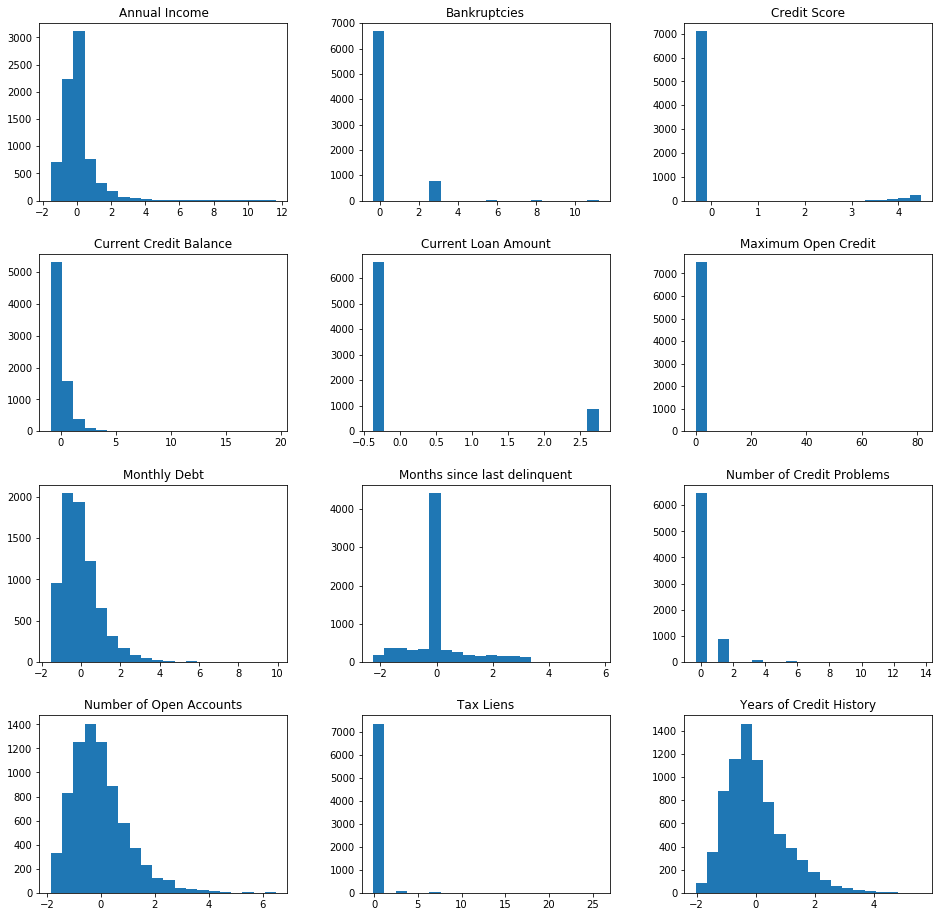

In [98]:
df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

### Функция для уделения выбросов в признаках

In [99]:
# def preprocess_outlier(df, col, threshold):
#     # можно по threshold отсекать, а можно и по квантилям
#     df.loc[df[col] > threshold, col] = np.nan
#     return df

# feature_name = 'Current Loan Amount'
# df_copy = preprocess_outlier(df_train, feature_name, threshold=9999999)
# df_test_copy = preprocess_outlier(df_test, feature_name, threshold=9999999)

# df_copy[feature_name].isna().sum()

### Функция для определения размера выборки

In [100]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

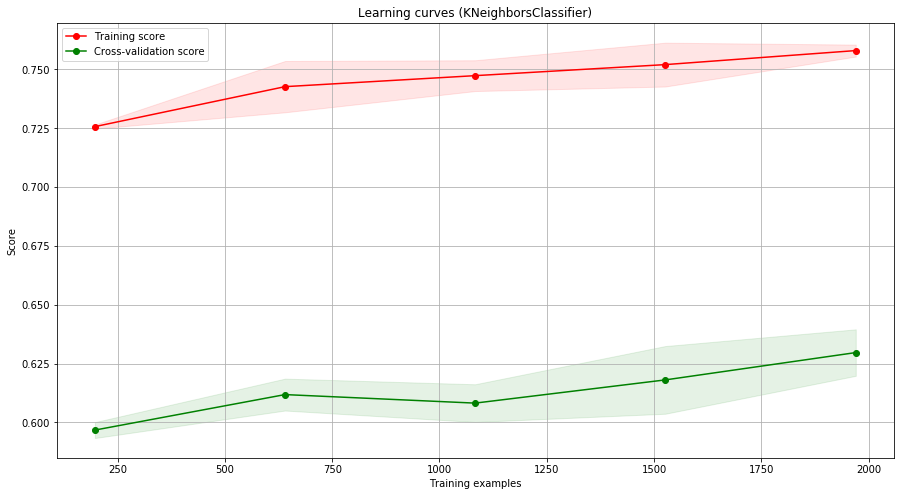

In [101]:
show_learning_curve_plot(model_knn, X_train_balanced, y_train_balanced)

### Функция выбора порога вероятности для определения класса

In [102]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [103]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=10
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[16:16:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
TRAIN

              prec

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [104]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
y_test_pred_probs

array([[0.4630714 , 0.5369286 ],
       [0.524456  , 0.47554398],
       [0.6524013 , 0.34759864],
       ...,
       [0.9741811 , 0.0258189 ],
       [0.41566932, 0.5843307 ],
       [0.01982021, 0.9801798 ]], dtype=float32)

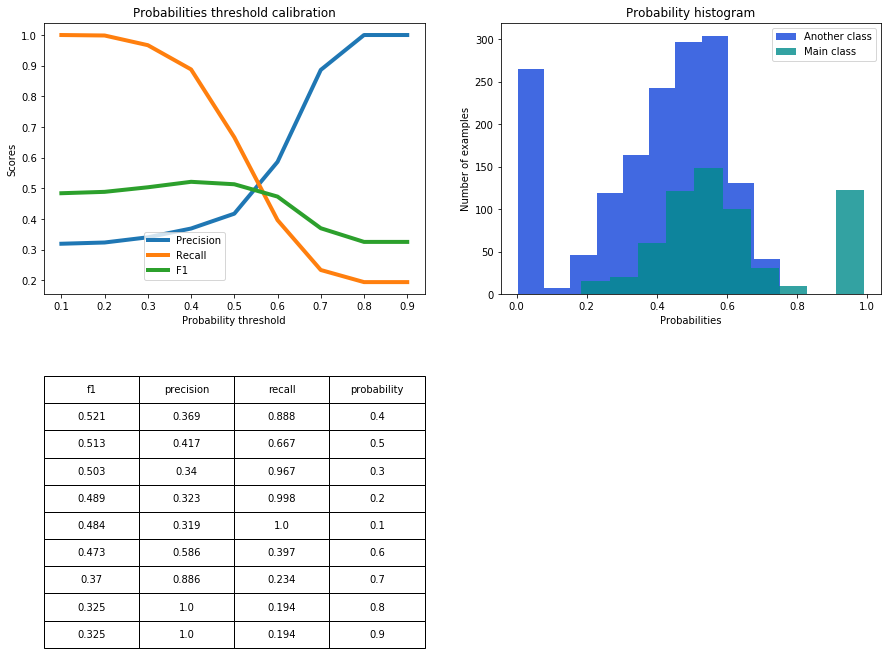

In [105]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Функция для определения важности признаков

In [106]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

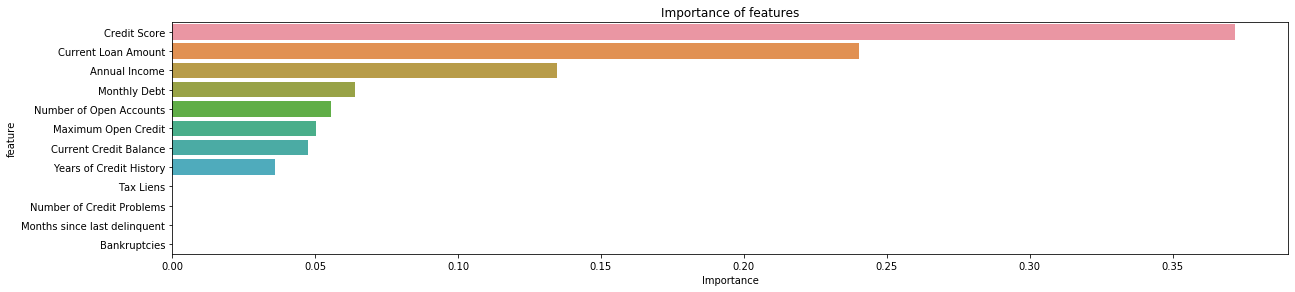

In [107]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=10)

In [108]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Annual Income',
 'Monthly Debt',
 'Number of Open Accounts',
 'Maximum Open Credit',
 'Current Credit Balance',
 'Years of Credit History',
 'Tax Liens',
 'Number of Credit Problems']

### Финальная модель<a class="anchor" id="final_model"></a>

In [109]:
final_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=10
                              )
final_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_xgb,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

[16:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=21, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)
TRAIN

              prec

C:\Users\lobapid3\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [110]:
filename = Path(MODELS_PATH/'finalized_model.sav')
pickle.dump(final_xgb, open(filename, 'wb'))